In [105]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets

In [9]:
data_path = "../../data_3eig/02_processed/02_npt/"
sel = 'name CA'

config_file = data_path + "step5_prod_0.tpr"
concat_traj_file = data_path + "prod_cat.xtc"

sampled_traj_name = data_path + 'sampled_traj_each10.xtc'

In [10]:
sampled_traj = mda.Universe(config_file, sampled_traj_name)
sampled_traj.trajectory.n_frames
sampled_ref_traj = mda.Universe(config_file, sampled_traj_name)
sampled_ref_traj.trajectory[-1]

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


< Timestep 260 with unit cell dimensions [71.12204 71.12204 71.12204 90.      90.      90.     ] >

Text(0, 0.5, 'RMSD')

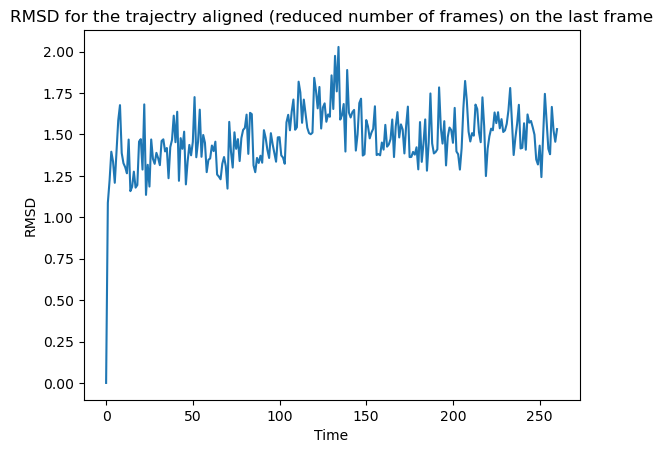

In [11]:
R = RMSD(sampled_traj, sampled_ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned (reduced number of frames) on the last frame")
plt.plot(R.results.rmsd[:,2])
plt.xlabel('Time')
plt.ylabel('RMSD')

In [12]:
matrix = diffusionmap.DistanceMatrix(sampled_traj, select=sel).run()

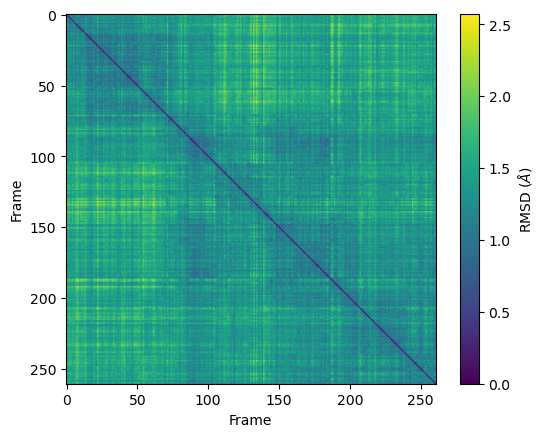

In [13]:
plt.imshow(matrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')

In [14]:
Z = linkage(squareform(matrix.results.dist_matrix), 'average')

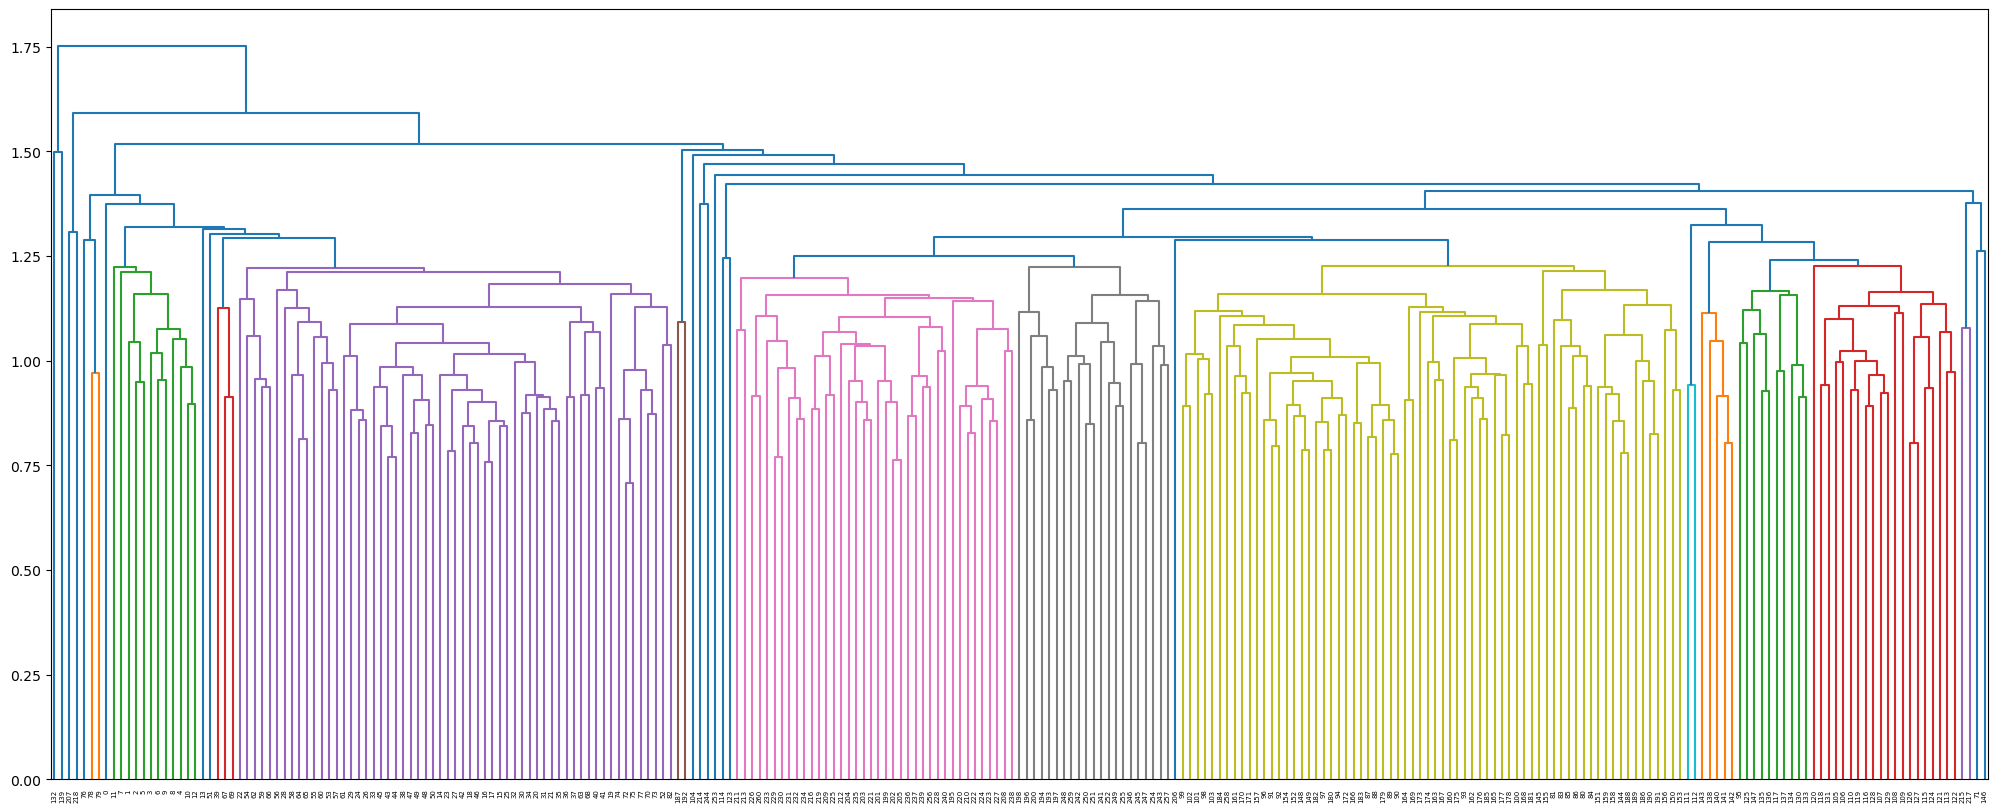

In [15]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [16]:
cl_labels = fcluster(Z, t=4, criterion='maxclust')

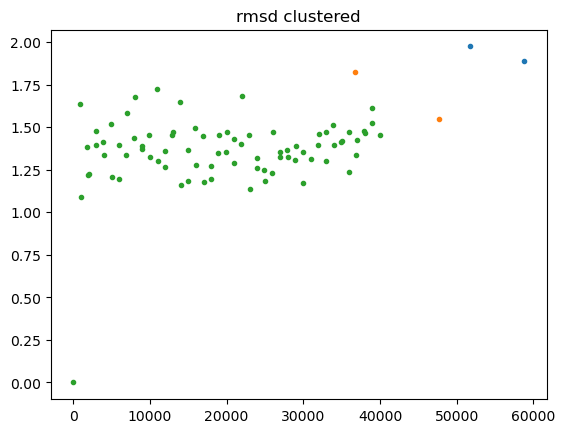

In [17]:
rmsd_arr = R.results.rmsd
plt.plot(rmsd_arr[cl_labels == 1][:, 1], rmsd_arr[cl_labels == 1][:, 2], '.')
plt.plot(rmsd_arr[cl_labels == 2][:, 1], rmsd_arr[cl_labels == 2][:, 2], '.')
plt.plot(rmsd_arr[cl_labels == 3][:, 1], rmsd_arr[cl_labels == 3][:, 2], '.')
plt.title("rmsd clustered")
plt.show()

# Clustering using dbscan

At first i am going to perform a pca, in order to reduce the dimensionality(it usually results in better clustering)

In [18]:
aligned_traj = mda.Universe(config_file, concat_traj_file) # taking the full traj

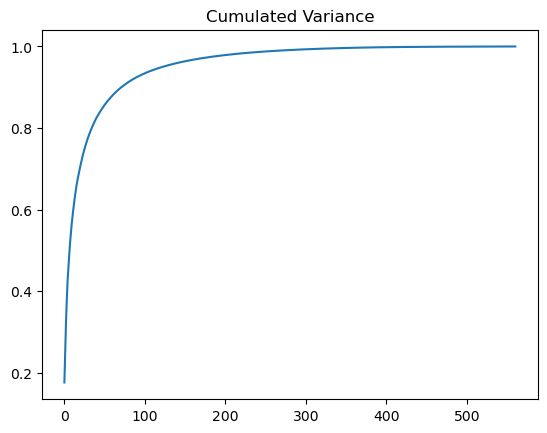

In [19]:
pca = PCA(aligned_traj, select=sel)
pca.run()

plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

In [128]:
# print([i for i in enumerate(pca.results.cumulated_variance)])

In [28]:
n_comp_90perc = 71

## Looking at the 2 component case, just to check for parameters and so on

In [33]:
pca_space_2 = pca.transform(aligned_traj.select_atoms(sel),2)

In [77]:
def genscore(i, j):
    mcs = i + 2
    eps = j / 10 
    clust = HDBSCAN(min_cluster_size = mcs,
                cluster_selection_epsilon = eps)
    labels = clust.fit_predict(pca_space_2)
    return metrics.silhouette_score(pca_space_2, labels, metric = 'euclidean')

In [82]:
sscore = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        sscore[i,j] = genscore(i,j)

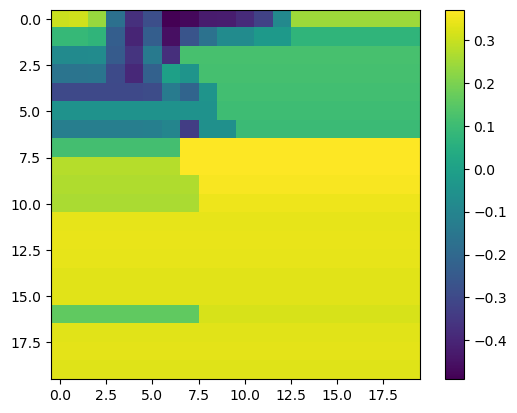

In [83]:
plt.imshow(sscore, cmap='viridis')
plt.colorbar()

In [86]:
# i want to keep the two big blobs separated
opt_mcs = 11
opt_eps = 0.5
clust = HDBSCAN(min_cluster_size = opt_mcs,
                cluster_selection_epsilon = opt_eps)
labels = clust.fit_predict(pca_space_2)

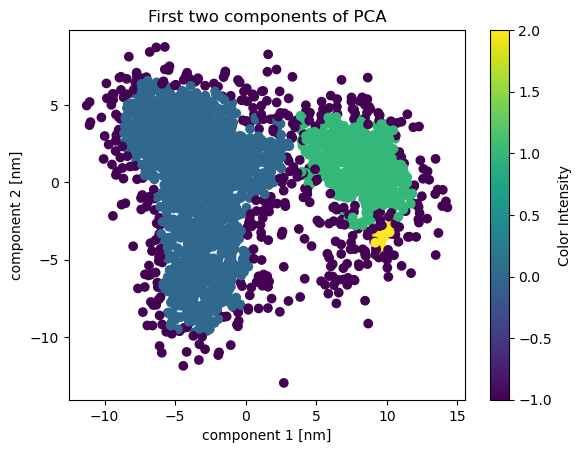

In [87]:
plt.title("First two components of PCA")
scatter = plt.scatter(pca_space_2[:, 0], pca_space_2[:, 1], c=labels)
plt.xlabel("component 1 [nm]")
plt.ylabel("component 2 [nm]")
plt.colorbar(scatter, label = 'Color Intensity')

# 10 components, capturing 60 % of the variance

In [129]:
pca_space = pca.transform(aligned_traj.select_atoms(sel),10)

In [136]:
def genscore(i, j):
    mcs = 11 - 3 + i
    eps = 0.5 - 0.3 + j / 10 
    clust = HDBSCAN(min_cluster_size = mcs,
                cluster_selection_epsilon = eps)
    clust = KMeans(n_clusters = i + 2)
    labels = clust.fit_predict(pca_space)
    return metrics.silhouette_score(pca_space, labels, metric = 'euclidean')

In [137]:
num = 10
sscore = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        sscore[i,j] = genscore(i,j)    

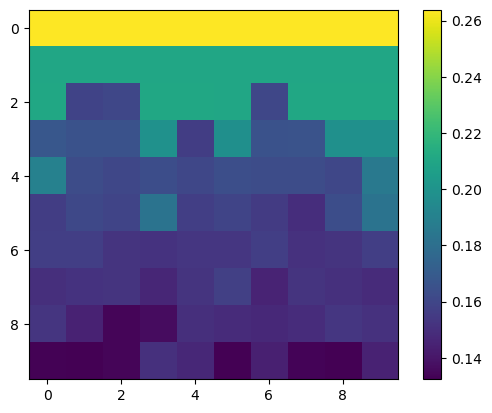

In [138]:
plt.imshow(sscore, cmap='viridis')
plt.colorbar()

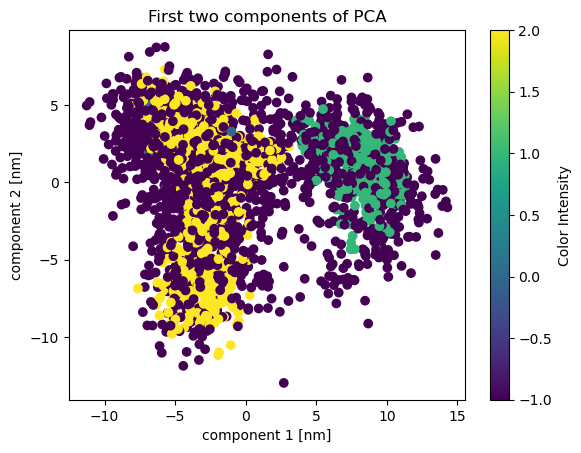

In [141]:
opt_mcs = 11 - 3 + 0
opt_eps = 0.5 - 0.3 + 3 / 10 
clust = HDBSCAN(min_cluster_size = opt_mcs,
                cluster_selection_epsilon = opt_eps)

labels = clust.fit_predict(pca_space)

plt.title("First two components of PCA")
scatter = plt.scatter(pca_space[:, 0], pca_space[:, 1], c=labels)
plt.xlabel("component 1 [nm]")
plt.ylabel("component 2 [nm]")
plt.colorbar(scatter, label = 'Color Intensity')

In [122]:
rmsd_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/03_analyzed/rmsd.csv"
rmsd = np.loadtxt(rmsd_file, delimiter = ",", skiprows = 1)

(2604,)

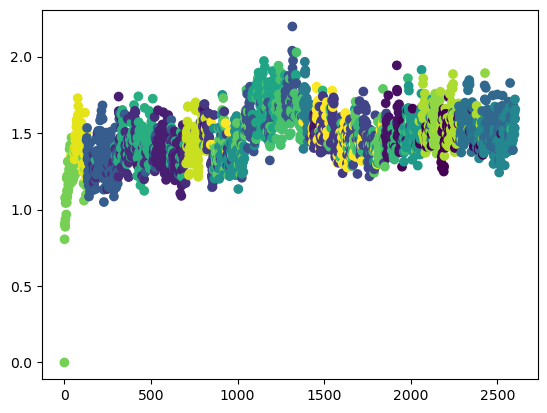

In [123]:
scatter = plt.scatter(rmsd[:, 0], rmsd[:, 1], c=labels)